In [1]:
from IPython.display import display
from IPython.core.debugger import set_trace

In [2]:
import os
import gc
import json
import math
import pprint
import argparse
from copy import deepcopy

import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [3]:
from models.student_teacher import StudentTeacher
from models.vae.parallelly_reparameterized_vae import ParallellyReparameterizedVAE
from models.vae.sequentially_reparameterized_vae import SequentiallyReparameterizedVAE

from datasets.loader import get_split_data_loaders, get_loader

from helpers.fid import train_fid_model
from helpers.layers import EarlyStopping
from helpers.grapher import Grapher
from helpers.metrics import calculate_consistency, calculate_fid, estimate_fisher

from helpers.utils import dummy_context, number_of_parameters
from helpers.utils import float_type, ones_like, append_to_csv
from helpers.utils import num_samples_in_loader, check_or_create_dir

from optimizers.adamnormgrad import AdamNormGrad

In [4]:
data_dir = '../102flowers'

In [5]:
cuda = tuple(torch.device(f'cuda:{x}') for x in range(torch.cuda.device_count()))

default_cuda = 3
device = cuda[default_cuda]

In [6]:
def img_tensor_to_numpy(img):
    img = img.cpu()
    return np.transpose(img, (1, 2, 0))


def img_numpy_to_tensor(img):
    return np.transpose(img, (2, 0, 1))


def center_crop(image, h, w):
    width, height = image.size
    
    left   = (width  - w)/2
    top    = (height - h)/2
    right  = (width  + w)/2
    bottom = (height + h)/2

    return image.crop((left, top, right, bottom))


'''
def load_flowers(filenames, c, h, w, dirpath=None):
    data = np.empty((len(filenames), c, h, w), dtype=np.int8)
    for idx,file in enumerate(filenames):
        file = os.path.join(dirpath, file)
        image = Image.open(file)
        image = center_crop(image, h, w)
        image = np.asarray(image)
        data[idx] = np.transpose(image, (2, 0, 1))
    return data
'''

def load_flowers(filenames, c, h, w, dirpath=None):
    data = np.empty((len(filenames), c, h, w), dtype=np.float32)
    for idx,file in enumerate(filenames):
        file = os.path.join(dirpath, file)
        image = Image.open(file)
        image = center_crop(image, h, w)
        image = np.asarray(image)
        data[idx] = np.transpose(image, (2, 0, 1)) / 255
    return data


def iter_dataset(dataset, batchsize=128):
    len_dataset, from_idx, to_idx = len(dataset), 0, batchsize
    while to_idx < len_dataset:
        yield dataset[from_idx:to_idx]
        from_idx, to_idx = to_idx, to_idx+batchsize
    if from_idx < len_dataset:
        yield dataset[from_idx:len_dataset]


def plot(org, rec, figsize=None):
    assert len(org) == len(rec)
    
    fig, axes = plt.subplots(len(org), 2, figsize=figsize)
    for o,r,axis in zip(org, rec, axes):
        axis[0].set_xticks([])
        axis[0].set_yticks([])
        
        axis[1].set_xticks([])
        axis[1].set_yticks([])
        
        axis[0].imshow(img_tensor_to_numpy(o))
        axis[1].imshow(img_tensor_to_numpy(r))
    
    plt.show()
    pass

In [7]:
optim_map = {
    "rmsprop" : optim.RMSprop,
    "adam"    : optim.Adam,
    "adamnorm": AdamNormGrad,
    "adadelta": optim.Adadelta,
    "sgd"     : optim.SGD,
    "lbfgs"   : optim.LBFGS
}

In [8]:
iter_idx = 0

In [9]:
def build_optimizer(model):
    return optim_map[args.optimizer](model.parameters(), lr=args.lr)


def vae_train(model, optimizer, dataset, batchsize=128):
    global iter_idx
    model.train()
    for data in iter_dataset(dataset, batchsize):
        data = torch.tensor(data, dtype=torch.float32, device=device)
        
        iter_idx += 1
        optimizer.zero_grad()

        output_map = model(data)
        loss_t = model.loss_function(output_map)
        loss_t['loss_mean'].backward()

        optimizer.step()
        
        del data
        del loss_t
        
        if iter_idx % 5000 == 0:
            _, generated = vae_test(model, dataset)
            gen_dataset = FlowerDataset(generated)
            print(iter_idx, get_fid(gen_dataset))
    
    return output_map['augmented']['data'].detach().cpu(), output_map['student']['x_reconstr'].detach().cpu()


def vae_test(model, dataset, batchsize=128):
    model.eval()
    with torch.no_grad():
        for data in iter_dataset(dataset, batchsize):
            data = torch.tensor(data, dtype=torch.float32, device=device)
            output_map = model(data)
            
            del data
    return output_map['augmented']['data'].detach().cpu(), output_map['student']['x_reconstr'].detach().cpu()

In [10]:
parser = argparse.ArgumentParser(description='LifeLong VAE Pytorch')

# Task parameters
parser.add_argument('--uid'                 , type=str, default=""                           , help="add a custom task-specific unique id; appended to name")
parser.add_argument('--task'                , type=str, default="mnist"                      , help='task to work on (can specify multiple) [mnist+cifar10+fashion+svhn_centered+svhn+clutter+permuted]')
parser.add_argument('--epochs'              , type=int, default=10             , metavar='N' , help='minimum number of epochs to train')
parser.add_argument('--continuous-size'     , type=int, default=32             , metavar='L' , help='latent size of continuous variable when using mixture or gaussian')
parser.add_argument('--discrete-size'       , type=int, default=1                            , help='initial dim of discrete variable when using mixture or gumbel')
parser.add_argument('--download'            , type=int, default=1                            , help='download dataset from s3')
parser.add_argument('--data-dir'            , type=str, default='./.datasets'  , metavar='DD', help='directory which contains input data')
parser.add_argument('--output-dir'          , type=str, default='./experiments', metavar='OD', help='directory which contains csv results')
parser.add_argument('--model-dir'           , type=str, default='.models'      , metavar='MD', help='directory which contains trained models')
parser.add_argument('--fid-model-dir'       , type=str, default='.models'                    , help='directory which contains trained FID models')
parser.add_argument('--calculate-fid-with'  , type=str, default=None                         , help='enables FID calc & uses model conv/inceptionv3')
parser.add_argument('--disable-augmentation', action='store_true'                            , help='disables student-teacher data augmentation')

# train / eval or resume modes
parser.add_argument('--resume-training-with', type=int, default=None, help='tries to load the model from model_dir and resume training')
parser.add_argument('--eval-with'           , type=int, default=None, help='tries to load the model from model_dir and evaluate the test dataset')
parser.add_argument('--eval-with-loader'    , type=int, default=None, help='if there are many loaders use ONLY this loader')

# Model parameters
parser.add_argument('--filter-depth'           , type=int, default=32                  , help='number of initial conv filter maps')
parser.add_argument('--reparam-type'           , type=str, default='isotropic_gaussian', help='isotropic_gaussian, discrete or mixture')
parser.add_argument('--layer-type'             , type=str, default='conv'              , help='dense or conv')
parser.add_argument('--nll-type'               , type=str, default='bernoulli'         , help='bernoulli or gaussian')
parser.add_argument('--vae-type'               , type=str, default='parallel'          , help='vae type [sequential or parallel]')
parser.add_argument('--normalization'          , type=str, default='groupnorm'         , help='normalization type: batchnorm/groupnorm/instancenorm/none')
parser.add_argument('--activation'             , type=str, default='elu'               , help='activation function')
parser.add_argument('--log-interval'           , type=int, default=10     , metavar='N', help='how many batches to wait before logging training status')
parser.add_argument('--disable-sequential'     , action='store_true', help='enables standard batch training')
parser.add_argument('--shuffle-minibatches'    , action='store_true', help='shuffles the student\'s minibatch')
parser.add_argument('--use-relational-encoder' , action='store_true', help='uses a relational network as the encoder projection layer')
parser.add_argument('--use-pixel-cnn-decoder'  , action='store_true', help='uses a pixel CNN decoder')
parser.add_argument('--disable-gated-conv'     , action='store_true', help='disables gated convolutional structure')
parser.add_argument('--disable-student-teacher', action='store_true', help='uses a standard VAE without Student-Teacher architecture')

# Optimization related
parser.add_argument('--early-stop', action='store_true', help='enable early stopping')
parser.add_argument('--optimizer' , type=str  , default="adamnorm", choices=optim_map.keys(), help="specify optimizer")
parser.add_argument('--lr'        , type=float, default=1e-3      , metavar='LR'            , help='learning rate')
parser.add_argument('--batch-size', type=int  , default=64        , metavar='N'             , help='input batch size for training')

# Regularizer related
parser.add_argument('--disable-regularizers', action='store_true', help='disables mutual info and consistency regularizers')
parser.add_argument('--monte-carlo-infogain', action='store_true', help='use the MC version of mutual information gain / false is analytic')
parser.add_argument('--continuous-mut-info' , type=float, default=0.0    , help='-continuous_mut_info * I(z_c; x) is applied (opposite dir of disc)')
parser.add_argument('--discrete-mut-info'   , type=float, default=0.0    , help='+discrete_mut_info * I(z_d; x) is applied')
parser.add_argument('--kl-reg'              , type=float, default=1.0    , help='hyperparameter to scale KL term in ELBO')
parser.add_argument('--generative-scale-var', type=float, default=1.0    , help='scale variance of prior in order to capture outliers')
parser.add_argument('--consistency-gamma'   , type=float, default=1.0    , help='consistency_gamma * KL(Q_student | Q_teacher)')
parser.add_argument('--likelihood-gamma'    , type=float, default=0.0    , help='log-likelihood regularizer between teacher and student, 0 is disabled')
parser.add_argument('--mut-clamp-strategy'  , type=str  , default="clamp", help='clamp mut info by norm / clamp / none')
parser.add_argument('--mut-clamp-value'     , type=float, default=100.0  , help='max / min clamp value if above strategy is clamp')
parser.add_argument('--ewc-gamma'           , type=float, default=0      , help='any value greater than 0 enables EWC with this hyper-parameter')

# Visdom parameters
parser.add_argument('--visdom-url' , type=str, default="localhost", help='visdom URL for graphs')
parser.add_argument('--visdom-port', type=int, default="9001"     , help='visdom port for graphs')

# Device parameters
parser.add_argument('--seed'   , type=int           , default=None , help='seed for numpy and pytorch')
parser.add_argument('--ngpu'   , type=int           , default=1    , help='number of gpus available')
parser.add_argument('--no-cuda', action='store_true', default=False, help='disables CUDA training')

_StoreTrueAction(option_strings=['--no-cuda'], dest='no_cuda', nargs=0, const=True, default=False, type=None, choices=None, help='disables CUDA training', metavar=None)

In [11]:
argv = '''--batch-size=300 --reparam-type=mixture --discrete-size=100 --continuous-size=40 --epochs=2 --filter-depth=32 --layer-type=conv --ngpu=1 --optimizer=adam --disable-regularizers --disable-sequential --task=mnist --uid=aim1 --calculate-fid-with=conv'''

args = parser.parse_args(argv.split())
args.cuda = not args.no_cuda and torch.cuda.is_available()
torch.cuda.set_device(default_cuda)


# handle randomness / non-randomness
if args.seed:
    print("I: Setting seed {}".format(args.seed))
    numpy.random.seed(args.seed)
    torch.manual_seed_all(args.seed)


pprint.pprint(args.__dict__, indent=4)

{   'activation': 'elu',
    'batch_size': 300,
    'calculate_fid_with': 'conv',
    'consistency_gamma': 1.0,
    'continuous_mut_info': 0.0,
    'continuous_size': 40,
    'cuda': True,
    'data_dir': './.datasets',
    'disable_augmentation': False,
    'disable_gated_conv': False,
    'disable_regularizers': True,
    'disable_sequential': True,
    'disable_student_teacher': False,
    'discrete_mut_info': 0.0,
    'discrete_size': 100,
    'download': 1,
    'early_stop': False,
    'epochs': 2,
    'eval_with': None,
    'eval_with_loader': None,
    'ewc_gamma': 0,
    'fid_model_dir': '.models',
    'filter_depth': 32,
    'generative_scale_var': 1.0,
    'kl_reg': 1.0,
    'layer_type': 'conv',
    'likelihood_gamma': 0.0,
    'log_interval': 10,
    'lr': 0.001,
    'model_dir': '.models',
    'monte_carlo_infogain': False,
    'mut_clamp_strategy': 'clamp',
    'mut_clamp_value': 100.0,
    'ngpu': 1,
    'nll_type': 'bernoulli',
    'no_cuda': False,
    'normalization':

In [12]:
c, h, w = 3, 500, 500
batch_size = 100

def get_flower_data():
    d1 = load_flowers(os.listdir(data_dir)[:batch_size], c, h, w, data_dir)
    d2 = load_flowers(os.listdir(data_dir)[batch_size:2*batch_size], c, h, w, data_dir)
    return [d1, d2]

In [13]:
img_shp = [c, h, w]
epoch = 500

vae         = ParallellyReparameterizedVAE(img_shp, kwargs=vars(args))
model       = StudentTeacher(vae, kwargs=vars(args))
optimizer   = build_optimizer(model.student)
dataset     = load_flowers(sorted(os.listdir(data_dir)), c, h, w, data_dir)

using mixture reparameterizer
building gated conv encoder...
building gated conv decoder...


In [14]:
def get_activations(dataset, model, batch_size=50, dims=2048, device='cpu', is_tqdm=False):
    model.eval()

    if batch_size > len(dataset):
        print(('Warning: batch size is bigger than the data size. '
               'Setting batch size to data size'))
        batch_size = len(dataset)

    dataloader = torch.utils.data.DataLoader(dataset,
                                             batch_size=batch_size,
                                             shuffle=False,
                                             drop_last=False,
                                             num_workers=0)

    start_idx = 0
    pred_arr = np.empty((len(dataset), dims))

    iterable_dataloader = tqdm(dataloader) if is_tqdm else dataloader
    for batch in iterable_dataloader:
        batch = batch.to(device)

        with torch.no_grad():
            pred = model(batch)[0]

        if pred.size(2) != 1 or pred.size(3) != 1:
            pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

        pred = pred.squeeze(3).squeeze(2).cpu().numpy()
        pred_arr[start_idx:start_idx + pred.shape[0]] = pred
        start_idx = start_idx + pred.shape[0]
    return pred_arr

def calculate_activation_statistics(dataset, model, batch_size=50, dims=2048, device='cpu'):
    act = get_activations(dataset, model, batch_size, dims, device)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

In [15]:
class FlowerDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.len = len(dataset)
        pass
    
    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        return self.dataset[idx, :]
    pass

In [16]:
import torch

from tqdm.auto import tqdm

from pytorch_fid.inception import InceptionV3
from pytorch_fid.fid_score import calculate_frechet_distance

dims = [64, 192, 768, 2048][3]
batch_size = 32
flower_dataset = FlowerDataset(dataset)

block_idx       = InceptionV3.BLOCK_INDEX_BY_DIM[dims]
inception_model = InceptionV3([block_idx]).to(device)
orig_m, orig_s  = calculate_activation_statistics(flower_dataset, inception_model, batch_size, dims, device)

In [17]:
def get_fid(gen_dataset):
    m2, s2 = calculate_activation_statistics(gen_dataset, inception_model, batch_size, dims, device)
    fid_value = calculate_frechet_distance(orig_m, orig_s, m2, s2)
    return fid_value

In [20]:
def run_n_epoch(epoch, bs):
    for e_idx in range(epoch):
        vae_train(model, optimizer, dataset, batchsize=bs)

In [18]:
%%timeit -r 1 -n 1
run_n_epoch(1)

/data/madhan/miniconda3/envs/pmi/lib/python3.6/site-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 0, fid: 373.5553410870299
32.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [21]:
n_flowers = 8189
bs = 16
it_sz = 60000

epoches = math.ceil(it_sz * bs / n_flowers)
run_n_epoch(epoches, bs)

/data/madhan/miniconda3/envs/pmi/lib/python3.6/site-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


5000 357.0643461442013
10000 366.35174059092003
15000 335.6141684947038
20000 334.47529040594986
25000 351.7339441865154
30000 308.68299348711696
35000 311.9770890505688
40000 299.9998900031359
45000 296.6328982245957
50000 288.8634531444062
55000 292.0763778451905
60000 294.7624046801521


In [22]:
model.save()

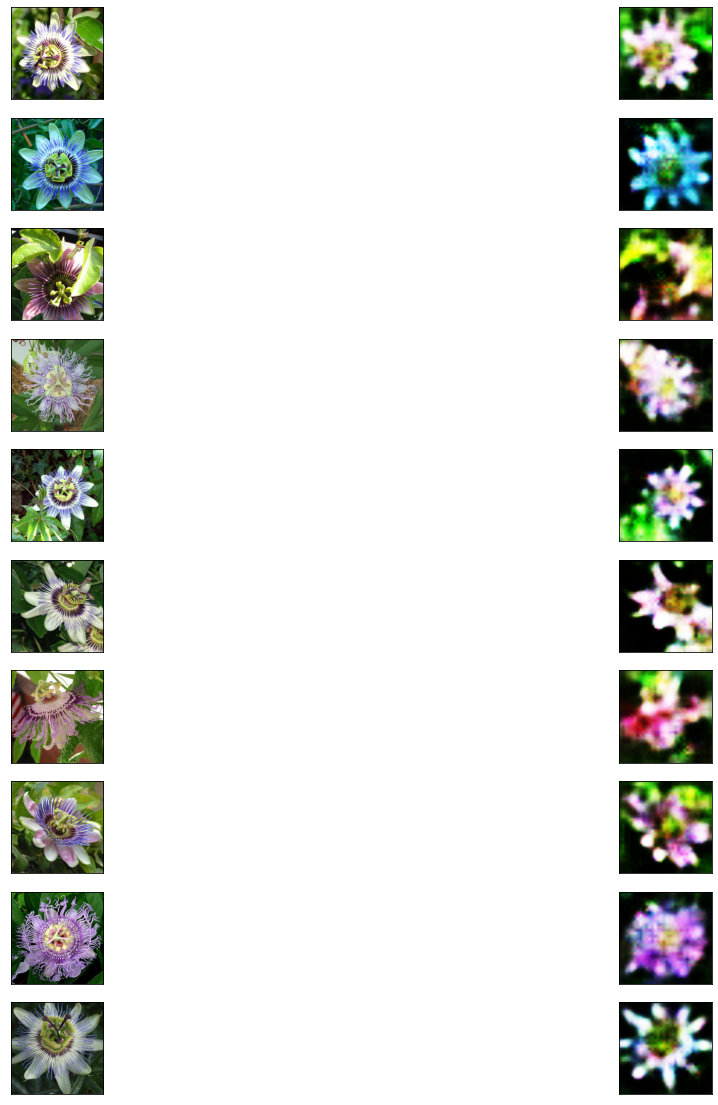

In [23]:
org, rec = vae_test(model, dataset[0:10])
plot(org, rec, figsize=(20, 20))